# library import

In [2]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle

import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re


import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

# 데이터 불러오기 및 전처리

In [4]:
image_path = "C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/"
dir_labelling = pd.read_csv(r"C:\Users\DI Lee\Desktop\crop_dataset\train\label\final\crop_captioning_label.csv", encoding='cp949')

In [5]:
dir_labelling.head()

,images,captions
0,V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000...,연녹색의 병반이 잎의 표면에 있는 것을 보아 잎마름병으로 판단됩니다
1,V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000...,병반이 잎의 표면에 있고 점이 연녹색인 것을 보아 잎마름병으로 판단됩니다
2,V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000...,잎의 표면에 연녹색의 병반이 있는 것으로 보아 잎마름병으로 사료됩니다
3,V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000...,연녹색 병반이 잎에 표면에 나 있는 것을 보아 잎마름병으로 판단됩니다
4,V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000...,잎의 표면에 연녹색 병반이 퍼져있는 것으로 보아 잎마름병으로 판단됩니다


In [6]:
ls = os.listdir(image_path)
print(f"total images (총 이미지 개수) : {len([f for f in ls if '.npy' not in f])}") #train 이미지 총 개수

total images (총 이미지 개수) : 114505


In [7]:
print(f"total captions (총 캡션 label 개수) : {len(dir_labelling)}")

total captions (총 캡션 label 개수) : 569365


# 4개의 이미지에 대해, 각 이미지에 5개씩 대응되는 라벨 문장 출력해보기

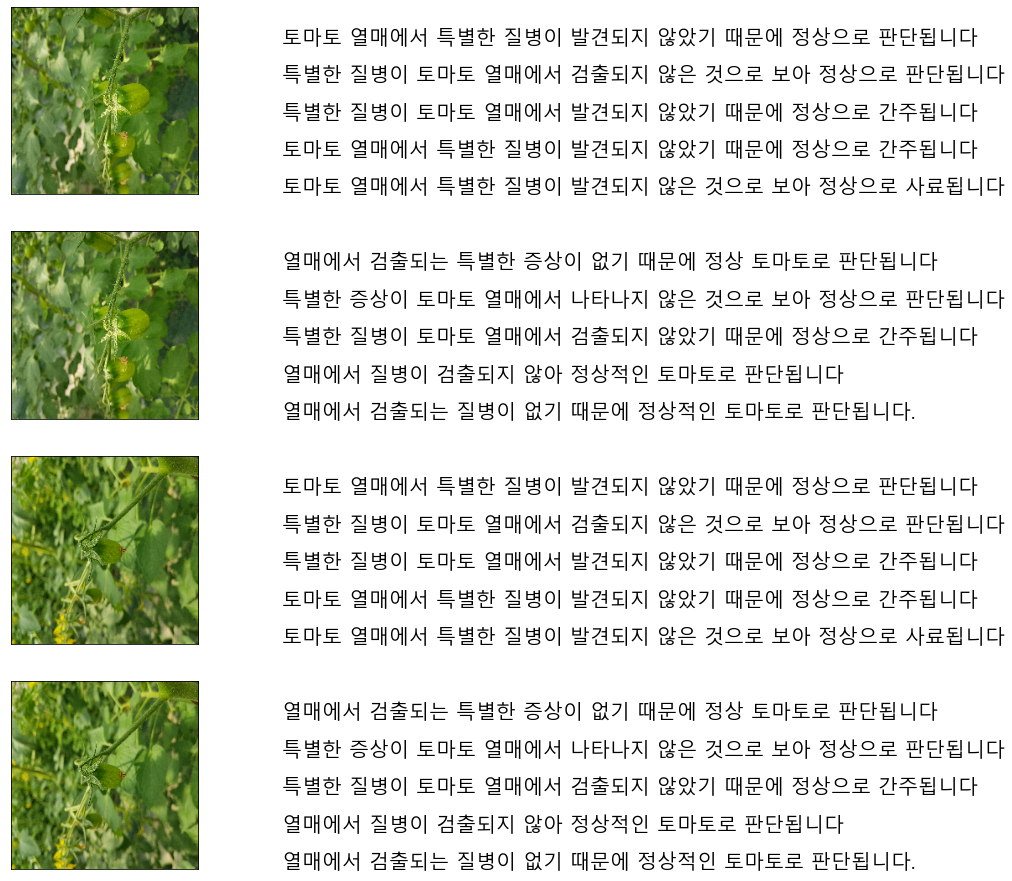

In [8]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in np.unique(dir_labelling['images'])[10:14]:
    filename = image_path + '/' + jpgfnm
    captions = list(dir_labelling["captions"].loc[dir_labelling["images"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

# Vocabulary size 확인

In [9]:
vocabulary = []
for text in dir_labelling.captions.values:
    vocabulary.extend(text.split()) #토크나이징을 공백(띄어쓰기) 기준으로 수행(나중에 형태소단위로 토크나이징 시도해볼 수 있음)

vocabulary = list(set(vocabulary))
print(f'vocabulary 사이즈는 {len(vocabulary)} 입니다.')

vocabulary 사이즈는 240 입니다.


In [10]:
vocabulary[:15]

['마른것을',
 '볼록한',
 '생각됩니다',
 '되어',
 '같은',
 '갈색',
 '이상',
 '진하지',
 '나타나',
 '퍼져있는',
 '병의',
 '나타나는',
 '담갈색의',
 '원형반점과',
 '확인할']

# 문장에 \<start>, \<end> 토큰 부착하기

In [11]:
attached_captions = []
for caption in dir_labelling['captions']:
    caption = '<start> ' + caption + ' <end>'
    attached_captions.append(caption)

In [12]:
attached_captions[:10]

['<start> 연녹색의 병반이 잎의 표면에 있는 것을 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 병반이 잎의 표면에 있고  점이 연녹색인 것을 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 잎의 표면에 연녹색의 병반이 있는 것으로 보아 잎마름병으로 사료됩니다 <end>',
 '<start> 연녹색 병반이 잎에 표면에 나 있는 것을 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 잎의 표면에 연녹색 병반이 퍼져있는 것으로 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 연녹색 점이 잎의 표면에  퍼져있는 것으로 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 볼록 튀어나와있는 병반이 연녹색인 것으로 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 잎에서 볼록하게 튀어나온 병반이 연녹색인 것으로 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 연녹색인 볼록한 병반이 있는 것으로 보아 잎마름병으로 판단됩니다 <end>',
 '<start> 볼라관 연녹색의 병반이 있는 것으로 보아 잎마름병으로 판단됩니다 <end>']

# 이미지 전체 경로 리스트(중복포함임)

In [13]:
all_img_name_vector = []
for file in dir_labelling['images']:
    full_img_path = image_path + file
    all_img_name_vector.append(full_img_path)

all_img_name_vector[:10]

['C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0000.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0001.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0001.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0001.jpg',
 'C:/Users/DI Lee/Desktop/crop_dataset/train/crop_images/V006_79_1_13_08_03_12_1_1825w_20200924_7_a0001.jpg',
 'C:/Users

# 개수 확인하기
* all_img_name_vector
* attached_captions

In [14]:
print(f'all_img_name_vector(전체 이미지 경로 개수) : {len(all_img_name_vector)}\nattached_captions(전체 캡션 개수) : {len(attached_captions)}')

all_img_name_vector(전체 이미지 경로 개수) : 569365
attached_captions(전체 캡션 개수) : 569365


# 이미지 특징 추출하는 모델(이미지 캡셔닝 모델의 인코더 부분) 정의하기

In [15]:
#이미지 읽어오는 함수
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet') #InceptionV3 이미지 특징 추출
new_input = image_model.input
hidden_layer = image_model.layers[-1].output #이미지 분류를 하지 않으므로 마지막 layer인 softmax 층을 제거함. 즉, 이미지에서 특징만 추출

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)#이미지 특징 추출 모델


In [16]:
#개수가 같은 전체 캡션 개수 배열(array)과 전체 이미지 이름 배열에 대해 일관된 순서로 데이터를 섞는다.
#두 배열에서 같은 행 인덱스에 있던 값은 데이터가 섞인 뒤에도 서로 같은 위치에 있다.
train_captions, img_name_vector = shuffle(attached_captions, all_img_name_vector, random_state=1)

### 이미지를 읽어오기 위해 이미지를 읽어오는 함수(load_image)에 각 이미지 이름을 대응(map)시킨다.

In [17]:
encoded_train = sorted(set(img_name_vector)) #집합으로 변환하는 이유: 코드 처리 속도 빠르게 하기 위해서, 중복없는 이미지만 있게 하려고(혹시 모르니까)
image_dataset = tf.data.Dataset.from_tensor_slices(encoded_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [18]:
print(len(image_dataset))

7118


### 이미지에서 특징을 추출하고, 각 특징을 넘파이 형식의 파일(.npy)로 변환하여 저장한다. 이후 이 넘파이 형식의 파일은 인코더에 입력된다.
- 넘파이 형식의 파일은 자료형과 행렬크기정보  등 어느 컴퓨터에나 배열(array)을 재구성하는데 필요한 모든 정보를 저장한다.

In [19]:
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████████████████████████████████████████████████████████████████████████| 7118/7118 [18:48<00:00,  6.31it/s]


# 캡션 전처리 및 토큰화
- 캡션을 토크나이징하여 중복 없는 단어들로 구성된 사전을 구축한다
- 구두점은 모두 제거함
- 혹시 사전에 없는 단어가 있으면 해당 단어는 \<unk> 토큰으로 대체함
- 그 후 각 단어에 인덱스를 부여하고, 단어:인덱스 형식으로 변형한다.
- 모델 학습을 위해 모든 문장의 길이를 맞춰줘야 하는데 이를 위해 모든 문장(시퀀스)를 가장 길이가 긴 문장의 길이에 맞춘다. 길이는 0으로 padding하여 맞춘다.

In [20]:
#토크나이저 생성
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token = '<unk>',
                                                  filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [21]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
print(train_seqs[:10])

[[2, 8, 84, 35, 16, 21, 6, 52, 50, 48, 20, 3], [2, 7, 31, 26, 30, 79, 12, 19, 4, 3], [2, 180, 11, 160, 161, 88, 68, 18, 4, 3], [2, 11, 46, 190, 14, 88, 41, 6, 5, 18, 4, 3], [2, 61, 39, 65, 66, 119, 28, 81, 114, 9, 44, 10, 3], [2, 9, 8, 95, 62, 59, 74, 27, 9, 44, 10, 3], [2, 32, 80, 107, 38, 17, 6, 5, 22, 20, 3], [2, 115, 55, 152, 73, 82, 103, 111, 6, 5, 34, 10, 3], [2, 8, 35, 40, 60, 21, 6, 52, 50, 13, 48, 4, 3], [2, 26, 30, 7, 31, 92, 120, 19, 4, 3]]


In [22]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [23]:
print(tokenizer.word_index)

{'<unk>': 1, '<start>': 2, '<end>': 3, '판단됩니다': 4, '보아': 5, '것으로': 6, '검은': 7, '잎에': 8, '애호박': 9, '의심됩니다': 10, '특별한': 11, '때문에': 12, '토마토': 13, '잎에서': 14, '질병이': 15, '반점이': 16, '있는': 17, '정상으로': 18, '파검은무늬병으로': 19, '사료됩니다': 20, '나타나는': 21, '잎마름병으로': 22, '점이': 23, '콩점무늬병으로': 24, '것을': 25, '파': 26, '발견되어': 27, '담황색': 28, '고추에': 29, '줄기에': 30, '포자층이': 31, '잎의': 32, '발견되지': 33, '고추탄저병으로': 34, '노란색': 35, '고추흰가루병으로': 36, '않았기': 37, '병반이': 38, '같은': 39, '반점과': 40, '않은': 41, '콩': 42, '검출되지': 43, '흰가루병으로': 44, '부정형': 45, '증상이': 46, '노균병으로': 47, '잎곰팡이병으로': 48, '나타나고': 49, '때': 50, '간주됩니다': 51, '보았을': 52, '있어': 53, '원형': 54, '말라': 55, '열매에서': 56, '병무늬가': 57, '앞면에': 58, '모양의': 59, '분생포자가': 60, '이슬과': 61, '서릿발': 62, '포자와': 63, '비틀어진': 64, '연한': 65, '흰색': 66, '엷은': 67, '않아': 68, '정상적인': 69, '포자가': 70, '생각됩니다': 71, '황갈색의': 72, '황갈색': 73, '곰팡이가': 74, '검출되는': 75, '없기': 76, '포자층을': 77, '황색을': 78, '있기': 79, '표면에': 80, '반점무늬가': 81, '포자덩어리와': 82, '움푹': 83, '분생포자와': 84, '보니': 85, '들어간': 86, '정상': 87, '나타나지'

In [24]:
print(tokenizer.index_word)

{1: '<unk>', 2: '<start>', 3: '<end>', 4: '판단됩니다', 5: '보아', 6: '것으로', 7: '검은', 8: '잎에', 9: '애호박', 10: '의심됩니다', 11: '특별한', 12: '때문에', 13: '토마토', 14: '잎에서', 15: '질병이', 16: '반점이', 17: '있는', 18: '정상으로', 19: '파검은무늬병으로', 20: '사료됩니다', 21: '나타나는', 22: '잎마름병으로', 23: '점이', 24: '콩점무늬병으로', 25: '것을', 26: '파', 27: '발견되어', 28: '담황색', 29: '고추에', 30: '줄기에', 31: '포자층이', 32: '잎의', 33: '발견되지', 34: '고추탄저병으로', 35: '노란색', 36: '고추흰가루병으로', 37: '않았기', 38: '병반이', 39: '같은', 40: '반점과', 41: '않은', 42: '콩', 43: '검출되지', 44: '흰가루병으로', 45: '부정형', 46: '증상이', 47: '노균병으로', 48: '잎곰팡이병으로', 49: '나타나고', 50: '때', 51: '간주됩니다', 52: '보았을', 53: '있어', 54: '원형', 55: '말라', 56: '열매에서', 57: '병무늬가', 58: '앞면에', 59: '모양의', 60: '분생포자가', 61: '이슬과', 62: '서릿발', 63: '포자와', 64: '비틀어진', 65: '연한', 66: '흰색', 67: '엷은', 68: '않아', 69: '정상적인', 70: '포자가', 71: '생각됩니다', 72: '황갈색의', 73: '황갈색', 74: '곰팡이가', 75: '검출되는', 76: '없기', 77: '포자층을', 78: '황색을', 79: '있기', 80: '표면에', 81: '반점무늬가', 82: '포자덩어리와', 83: '움푹', 84: '분생포자와', 85: '보니', 86: '들어간', 87: '정상', 88: '나

In [25]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector =  tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [26]:
cap_vector[:5]

array([[  2,   8,  84,  35,  16,  21,   6,  52,  50,  48,  20,   3,   0,
          0,   0,   0,   0],
       [  2,   7,  31,  26,  30,  79,  12,  19,   4,   3,   0,   0,   0,
          0,   0,   0,   0],
       [  2, 180,  11, 160, 161,  88,  68,  18,   4,   3,   0,   0,   0,
          0,   0,   0,   0],
       [  2,  11,  46, 190,  14,  88,  41,   6,   5,  18,   4,   3,   0,
          0,   0,   0,   0],
       [  2,  61,  39,  65,  66, 119,  28,  81, 114,   9,  44,  10,   3,
          0,   0,   0,   0]])

In [27]:
cap_vector.shape

(569365, 17)

### 훈련, 검증데이터를 80:20 비율로 나누기

In [28]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [29]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(455492, 455492, 113873, 113873)

### 모델 훈련에 사용하기 위해 텐서플로우의 data.dataset을 생성 (tf.data.dataset)

In [30]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode("utf-8")+'.npy')
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# validation dataset 생성

In [31]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_val) // BATCH_SIZE

def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode("utf-8")+'.npy')
    return img_tensor, cap

val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 트랜스포머 모델 만들기(이미지 캡셔닝 모델의 디코더 부분)★★★

### positional encoding (입력 토큰의 문장에서의 위치 정보를 알려줌)
- 입력 벡터의 인덱스가 홀수면 코사인함수를 이용하여 위치 벡터를 생성하고 입력 벡터의 인덱스가 짝수면 사인함수를 이용하여 위치 벡터를 생성함.
- 그 다음 각 위치 벡터를 해당 벡터에 대응되는 입력 벡터에 더한다.

In [32]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding_1d(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)
    #짝수 인덱스에는 사인함수를 적용 
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    #홀수 인덱스에는 코사인 함수를 적용
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
    assert d_model % 2 == 0

    # 첫번째 d_model/2는 행 임베딩을 인코딩하고 두번째 d_model/2는 열 임베딩을 인코딩한다.
    row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
    col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

    angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
    angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

    # apply sin and cos to odd and even indices resp.
    angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
    pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

### Multi-Head Attention
- self attention 층을 여러 겹 쌓은 것을 Multi-Head Attention이라고 부른다.
- query(q), key(k), value(v) 벡터를 생성하는데, k와 v의 길이는 같아야 한다. 나중에 어텐션 스코어를 구할 때 두 벡터를 내적하여 하나의 스칼라 값을 구하기 때문이다.


In [33]:
#패드 토큰 마스킹하기 - 패딩한 토큰을 모델이 입력으로 취급하지 않도록 한다.
#위에서 0으로 패딩된 패드 토큰은 1을 출력하고 나머지 토큰은 0을 출력하도록 함수를 생성함.
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

#look ahead mask를 생성. look ahead mask는 모델의 학습을 위해 전체 시퀀스에서 현재 예측해야 하는 시퀀스부터 미래에 예측해야 하는 시퀀스까지 모두 마스킹하는 것.
#예를 들어 세 번째 토큰을 예측하기 위해 첫번째, 두번째 토큰만 사용하고 세번째 토큰부터는 마스킹하는 것.
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

#query, key, value로 attention weight를 계산하는데, query와 key를 내적하여 나온 스칼라 값(attention score)에 key의 차원 수(dk)의 제곱근을 나눠주어 스칼라값을 스케일링 해준다.
#스케일링 하는 이유: key의 차원이 커질수록 query와 key에 대한 내적 계산시 내적된 값이 커지는 문제를 보완하기 위해 수행.
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  #마스킹되는 위치에 절댓값이 매우 작은 음수 값을 넣는다(-0.000000001)
  #나중에 소프트맥스 함수를 거치면 이 마스킹된 위치의 값은 거의 0으로 수렴한다.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9) 

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [34]:
#Multi-Head Attention : 어텐션을 여러번 병렬로 처리한다.
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights


### Point-Wise Feed Forward Neural Network

- 두 개의 완전 연결된 층(layer)으로 구성된 네트워크로, 활성화 함수로는 ReLU함수를 사용한다.
- 트랜스포머 모델에서의 인코더 구조, 디코더 구조 모두에 공통적으로 가지고 있다.

In [35]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model) #(batch_size, seq_len, d_model)
                ])

### 트랜스포머의 인코더 구조 정의

In [36]:
#인코더 층(layer)을 정의하기
  #<구성 요소>
  # 패딩 마스크가 포함된 Multi-Head Attention
  # Point-Wise Feed Forward Neural Network

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        #층 정규화(layer normalization)
        #모델 학습을 돕기 위해 텐서의 마지막 차원에 대한 평균과 분산을 구하고 평균, 분산값을 이용한 수식으로 값을 정규화하는 과정
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        #드롭아웃(Drop Out)
        #과대적합(Overfitting)을 방지하기 위해 rate의 확률로 뉴런을 제거하는 기법
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)


    def call(self, x, training, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        #잔차 연결(x + attn_output) -> 그래디언트 소멸 문제를 피하는데 도움을 준다.
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        #잔차 연결(out1 + ffn_output) -> 그래디언트 소멸 문제를 피하는데 도움을 준다.
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2

In [37]:
#인코더 구조를 정의하기
  #<구성 요소>
  # 입력 임베딩 벡터
  # 위치 인코딩
  # N개의 인코더 층

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
        self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                          for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

### 트랜스포머 모델의 디코더 구조 정의

In [38]:
#디코더 층(layer)을 정의하기
  #<구성 요소>
  # look-ahead 마스크와 패딩 마스크가 포함된 Masked Multi-Head Attention
  # 패딩 마스크가 포함된 Multi-Head Attention. Key, Value는 인코더의 결과물을 입력값으로 받고, Query는 Masked Multi-Head Attention 층의 결과물을 입력값으로 받는다.
  # Point-Wise Feed Forward Neural Network

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None): # enc_output.shape == (batch_size, input_seq_len, d_model)
      
        # self-attention 진행 중에 현재의 query가 미래의 token을 고려하지 않도록 하기 위해 look-ahead mask를 사용함
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        # 인코더 출력값의 패딩된 값과 디코더 입력값의 패딩된 값을 피하기 위해 padding mask를 사용한다
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [39]:
#디코더 구조를 정의하기
  #<구성 요소>
  # 출력 임베딩 벡터
  # 위치 인코딩
  # N개의 디코더 층

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
      
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## 트랜스포머 모델 구축하기
- 인코더 구조, 디코더 구조, 마지막 선형 층으로 구성된다.
- 디코더의 출력 결과는 선형 층의 입력값으로 들어가고, 이렇게 해서 생성된 최종 결과물이 반환된다.

In [40]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                      target_vocab_size,max_pos_encoding, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
        dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

## 트랜스포머 모델 훈련을 위한 초매개변수(Hyperparameters) 설정하기

In [41]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1 

In [42]:
#커스터마이징한 학습률 스케줄러 생성
#'Attention is all you need' 논문 즉, Transformer 모델을 소개한 이 논문에서 사용한 학습률 스케줄러를 생성함.
#학습률 스케줄러의 역할: 모델 학습과정에서 미리 학습 일정을 정해두고 그 일정에 따라 학습률을 동적으로 변경해줌

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [43]:
#학습률, 옵티마이저, 손실함수 정의하기
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
   
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [44]:
#훈련 오차 및 정확도 선언
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

#트랜스포머
transformer = Transformer(num_layer,
                          d_model,
                          num_heads,
                          dff,
                          row_size,
                          col_size,
                          target_vocab_size, 
                          max_pos_encoding=target_vocab_size,
                          rate=dropout_rate)

In [182]:
print(transformer)

# 모델 체크포인트

In [47]:
checkpoint_path = "C:/Users/DI Lee/Desktop/weight/checkpoints_transformer"
checkpoint = tf.train.Checkpoint(optimizer = optimizer, model = transformer)
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep = 5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    #checkpoint_path에 가장 최신의 체크포인트를 저장한다
    ckpt.restore(ckpt_manager, latest_checkpoint)

# 모델 훈련
- 이미지에서 추출된 특징이 담겨있는 .npy 파일과 정답 라벨 문장(타겟 문장)을 트랜스포머 모델에 입력하면 그 이미지에 대한 예상 문장(캡션)을 출력함.
- 결과에 대한 loss 및 그레이디언트 계산 후 loss가 최소가 되도록 훈련을 반복함

In [48]:
def create_masks_decoder(tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return combined_mask

In [49]:
@tf.function
def train_step(img_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    dec_mask = create_masks_decoder(tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [51]:
loss_plot = []
for epoch in tqdm(range(30)):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (img_tensor, tar)) in enumerate(dataset):
        train_step(img_tensor, tar)
      
        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
            epoch + 1, batch, train_loss.result(), train_accuracy.result()))
#     loss_plot.append(total_loss / num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 0.2854 Accuracy 0.5488
Epoch 1 Batch 50 Loss 0.3115 Accuracy 0.5687
Epoch 1 Batch 100 Loss 0.3057 Accuracy 0.5701
Epoch 1 Batch 150 Loss 0.3061 Accuracy 0.5704
Epoch 1 Batch 200 Loss 0.3029 Accuracy 0.5715
Epoch 1 Batch 250 Loss 0.3012 Accuracy 0.5718
Epoch 1 Batch 300 Loss 0.3023 Accuracy 0.5705
Epoch 1 Batch 350 Loss 0.3023 Accuracy 0.5704
Epoch 1 Batch 400 Loss 0.3017 Accuracy 0.5706
Epoch 1 Batch 450 Loss 0.3012 Accuracy 0.5702
Epoch 1 Batch 500 Loss 0.3008 Accuracy 0.5704
Epoch 1 Batch 550 Loss 0.3009 Accuracy 0.5704
Epoch 1 Batch 600 Loss 0.3002 Accuracy 0.5707
Epoch 1 Batch 650 Loss 0.2998 Accuracy 0.5709
Epoch 1 Batch 700 Loss 0.2994 Accuracy 0.5708
Epoch 1 Batch 750 Loss 0.2993 Accuracy 0.5708
Epoch 1 Batch 800 Loss 0.2989 Accuracy 0.5709
Epoch 1 Batch 850 Loss 0.2986 Accuracy 0.5712
Epoch 1 Batch 900 Loss 0.2985 Accuracy 0.5713
Epoch 1 Batch 950 Loss 0.2984 Accuracy 0.5712
Epoch 1 Batch 1000 Loss 0.2983 Accuracy 0.5713
Epoch 1 Batch 1050 Loss 0.2984 Accur

  3%|██▋                                                                             | 1/30 [16:31<7:59:10, 991.40s/it]

Epoch 1 Loss 0.2854 Accuracy 0.5735
Time taken for 1 epoch: 991.3959724903107 secs

Epoch 2 Batch 0 Loss 0.2672 Accuracy 0.5713
Epoch 2 Batch 50 Loss 0.2736 Accuracy 0.5747
Epoch 2 Batch 100 Loss 0.2747 Accuracy 0.5737
Epoch 2 Batch 150 Loss 0.2741 Accuracy 0.5743
Epoch 2 Batch 200 Loss 0.2740 Accuracy 0.5745
Epoch 2 Batch 250 Loss 0.2741 Accuracy 0.5739
Epoch 2 Batch 300 Loss 0.2744 Accuracy 0.5733
Epoch 2 Batch 350 Loss 0.2747 Accuracy 0.5737
Epoch 2 Batch 400 Loss 0.2749 Accuracy 0.5736
Epoch 2 Batch 450 Loss 0.2747 Accuracy 0.5734
Epoch 2 Batch 500 Loss 0.2747 Accuracy 0.5735
Epoch 2 Batch 550 Loss 0.2748 Accuracy 0.5737
Epoch 2 Batch 600 Loss 0.2744 Accuracy 0.5740
Epoch 2 Batch 650 Loss 0.2743 Accuracy 0.5740
Epoch 2 Batch 700 Loss 0.2742 Accuracy 0.5741
Epoch 2 Batch 750 Loss 0.2744 Accuracy 0.5739
Epoch 2 Batch 800 Loss 0.2745 Accuracy 0.5743
Epoch 2 Batch 850 Loss 0.2747 Accuracy 0.5743
Epoch 2 Batch 900 Loss 0.2748 Accuracy 0.5743
Epoch 2 Batch 950 Loss 0.2748 Accuracy 0.5743

  7%|█████▎                                                                          | 2/30 [33:01<7:42:11, 990.43s/it]

Epoch 2 Loss 0.2693 Accuracy 0.5758
Time taken for 1 epoch: 989.746640920639 secs

Epoch 3 Batch 0 Loss 0.2587 Accuracy 0.5781
Epoch 3 Batch 50 Loss 0.2669 Accuracy 0.5737
Epoch 3 Batch 100 Loss 0.2647 Accuracy 0.5762
Epoch 3 Batch 150 Loss 0.2655 Accuracy 0.5765
Epoch 3 Batch 200 Loss 0.2648 Accuracy 0.5771
Epoch 3 Batch 250 Loss 0.2652 Accuracy 0.5764
Epoch 3 Batch 300 Loss 0.2654 Accuracy 0.5758
Epoch 3 Batch 350 Loss 0.2654 Accuracy 0.5758
Epoch 3 Batch 400 Loss 0.2655 Accuracy 0.5756
Epoch 3 Batch 450 Loss 0.2655 Accuracy 0.5752
Epoch 3 Batch 500 Loss 0.2656 Accuracy 0.5752
Epoch 3 Batch 550 Loss 0.2654 Accuracy 0.5754
Epoch 3 Batch 600 Loss 0.2650 Accuracy 0.5758
Epoch 3 Batch 650 Loss 0.2654 Accuracy 0.5756
Epoch 3 Batch 700 Loss 0.2651 Accuracy 0.5757
Epoch 3 Batch 750 Loss 0.2656 Accuracy 0.5754
Epoch 3 Batch 800 Loss 0.2655 Accuracy 0.5757
Epoch 3 Batch 850 Loss 0.2658 Accuracy 0.5757
Epoch 3 Batch 900 Loss 0.2657 Accuracy 0.5759
Epoch 3 Batch 950 Loss 0.2657 Accuracy 0.5757


 10%|████████                                                                        | 3/30 [49:28<7:25:06, 989.14s/it]

Epoch 3 Loss 0.2621 Accuracy 0.5768
Time taken for 1 epoch: 987.6165282726288 secs

Epoch 4 Batch 0 Loss 0.2585 Accuracy 0.5703
Epoch 4 Batch 50 Loss 0.2601 Accuracy 0.5776
Epoch 4 Batch 100 Loss 0.2620 Accuracy 0.5751
Epoch 4 Batch 150 Loss 0.2613 Accuracy 0.5766
Epoch 4 Batch 200 Loss 0.2606 Accuracy 0.5770
Epoch 4 Batch 250 Loss 0.2602 Accuracy 0.5767
Epoch 4 Batch 300 Loss 0.2606 Accuracy 0.5755
Epoch 4 Batch 350 Loss 0.2604 Accuracy 0.5758
Epoch 4 Batch 400 Loss 0.2603 Accuracy 0.5761
Epoch 4 Batch 450 Loss 0.2604 Accuracy 0.5758
Epoch 4 Batch 500 Loss 0.2601 Accuracy 0.5757
Epoch 4 Batch 550 Loss 0.2600 Accuracy 0.5759
Epoch 4 Batch 600 Loss 0.2598 Accuracy 0.5762
Epoch 4 Batch 650 Loss 0.2596 Accuracy 0.5763
Epoch 4 Batch 700 Loss 0.2594 Accuracy 0.5764
Epoch 4 Batch 750 Loss 0.2593 Accuracy 0.5763
Epoch 4 Batch 800 Loss 0.2592 Accuracy 0.5765
Epoch 4 Batch 850 Loss 0.2590 Accuracy 0.5766
Epoch 4 Batch 900 Loss 0.2588 Accuracy 0.5767
Epoch 4 Batch 950 Loss 0.2590 Accuracy 0.5765

 13%|██████████▍                                                                   | 4/30 [1:05:56<7:08:22, 988.56s/it]

Epoch 4 Loss 0.2553 Accuracy 0.5776
Time taken for 1 epoch: 987.6604027748108 secs

Epoch 5 Batch 0 Loss 0.2478 Accuracy 0.5791
Epoch 5 Batch 50 Loss 0.2531 Accuracy 0.5786
Epoch 5 Batch 100 Loss 0.2533 Accuracy 0.5770
Epoch 5 Batch 150 Loss 0.2524 Accuracy 0.5782
Epoch 5 Batch 200 Loss 0.2520 Accuracy 0.5782
Epoch 5 Batch 250 Loss 0.2523 Accuracy 0.5777
Epoch 5 Batch 300 Loss 0.2527 Accuracy 0.5769
Epoch 5 Batch 350 Loss 0.2527 Accuracy 0.5771
Epoch 5 Batch 400 Loss 0.2525 Accuracy 0.5775
Epoch 5 Batch 450 Loss 0.2526 Accuracy 0.5768
Epoch 5 Batch 500 Loss 0.2527 Accuracy 0.5768
Epoch 5 Batch 550 Loss 0.2527 Accuracy 0.5769
Epoch 5 Batch 600 Loss 0.2527 Accuracy 0.5771
Epoch 5 Batch 650 Loss 0.2528 Accuracy 0.5773
Epoch 5 Batch 700 Loss 0.2527 Accuracy 0.5774
Epoch 5 Batch 750 Loss 0.2527 Accuracy 0.5772
Epoch 5 Batch 800 Loss 0.2526 Accuracy 0.5774
Epoch 5 Batch 850 Loss 0.2526 Accuracy 0.5776
Epoch 5 Batch 900 Loss 0.2525 Accuracy 0.5777
Epoch 5 Batch 950 Loss 0.2525 Accuracy 0.5775

 17%|█████████████                                                                 | 5/30 [1:22:25<6:51:57, 988.69s/it]

Epoch 5 Loss 0.2506 Accuracy 0.5784
Time taken for 1 epoch: 988.921569108963 secs

Epoch 6 Batch 0 Loss 0.2507 Accuracy 0.5908
Epoch 6 Batch 50 Loss 0.2512 Accuracy 0.5788
Epoch 6 Batch 100 Loss 0.2503 Accuracy 0.5779
Epoch 6 Batch 150 Loss 0.2493 Accuracy 0.5783
Epoch 6 Batch 200 Loss 0.2487 Accuracy 0.5792
Epoch 6 Batch 250 Loss 0.2483 Accuracy 0.5789
Epoch 6 Batch 300 Loss 0.2491 Accuracy 0.5779
Epoch 6 Batch 350 Loss 0.2488 Accuracy 0.5779
Epoch 6 Batch 400 Loss 0.2488 Accuracy 0.5779
Epoch 6 Batch 450 Loss 0.2489 Accuracy 0.5775
Epoch 6 Batch 500 Loss 0.2489 Accuracy 0.5775
Epoch 6 Batch 550 Loss 0.2490 Accuracy 0.5775
Epoch 6 Batch 600 Loss 0.2489 Accuracy 0.5778
Epoch 6 Batch 650 Loss 0.2487 Accuracy 0.5779
Epoch 6 Batch 700 Loss 0.2486 Accuracy 0.5780
Epoch 6 Batch 750 Loss 0.2485 Accuracy 0.5779
Epoch 6 Batch 800 Loss 0.2482 Accuracy 0.5781
Epoch 6 Batch 850 Loss 0.2481 Accuracy 0.5783
Epoch 6 Batch 900 Loss 0.2480 Accuracy 0.5785
Epoch 6 Batch 950 Loss 0.2480 Accuracy 0.5783


 20%|███████████████▌                                                              | 6/30 [1:38:54<6:35:35, 988.97s/it]

Epoch 6 Loss 0.2472 Accuracy 0.5789
Time taken for 1 epoch: 989.5023403167725 secs

Epoch 7 Batch 0 Loss 0.2676 Accuracy 0.5547
Epoch 7 Batch 50 Loss 0.2469 Accuracy 0.5789
Epoch 7 Batch 100 Loss 0.2466 Accuracy 0.5783
Epoch 7 Batch 150 Loss 0.2456 Accuracy 0.5790
Epoch 7 Batch 200 Loss 0.2451 Accuracy 0.5793
Epoch 7 Batch 250 Loss 0.2450 Accuracy 0.5792
Epoch 7 Batch 300 Loss 0.2457 Accuracy 0.5780
Epoch 7 Batch 350 Loss 0.2458 Accuracy 0.5783
Epoch 7 Batch 400 Loss 0.2459 Accuracy 0.5783
Epoch 7 Batch 450 Loss 0.2463 Accuracy 0.5778
Epoch 7 Batch 500 Loss 0.2465 Accuracy 0.5777
Epoch 7 Batch 550 Loss 0.2464 Accuracy 0.5778
Epoch 7 Batch 600 Loss 0.2462 Accuracy 0.5782
Epoch 7 Batch 650 Loss 0.2462 Accuracy 0.5782
Epoch 7 Batch 700 Loss 0.2464 Accuracy 0.5781
Epoch 7 Batch 750 Loss 0.2462 Accuracy 0.5781
Epoch 7 Batch 800 Loss 0.2462 Accuracy 0.5782
Epoch 7 Batch 850 Loss 0.2460 Accuracy 0.5784
Epoch 7 Batch 900 Loss 0.2459 Accuracy 0.5786
Epoch 7 Batch 950 Loss 0.2459 Accuracy 0.5785

 23%|██████████████████▏                                                           | 7/30 [1:55:24<6:19:11, 989.18s/it]

Epoch 7 Loss 0.2437 Accuracy 0.5794
Time taken for 1 epoch: 989.6071636676788 secs

Epoch 8 Batch 0 Loss 0.2590 Accuracy 0.5635
Epoch 8 Batch 50 Loss 0.2439 Accuracy 0.5801
Epoch 8 Batch 100 Loss 0.2429 Accuracy 0.5787
Epoch 8 Batch 150 Loss 0.2427 Accuracy 0.5789
Epoch 8 Batch 200 Loss 0.2424 Accuracy 0.5795
Epoch 8 Batch 250 Loss 0.2426 Accuracy 0.5789
Epoch 8 Batch 300 Loss 0.2428 Accuracy 0.5780
Epoch 8 Batch 350 Loss 0.2427 Accuracy 0.5783
Epoch 8 Batch 400 Loss 0.2425 Accuracy 0.5785
Epoch 8 Batch 450 Loss 0.2426 Accuracy 0.5780
Epoch 8 Batch 500 Loss 0.2427 Accuracy 0.5780
Epoch 8 Batch 550 Loss 0.2430 Accuracy 0.5781
Epoch 8 Batch 600 Loss 0.2429 Accuracy 0.5784
Epoch 8 Batch 650 Loss 0.2428 Accuracy 0.5785
Epoch 8 Batch 700 Loss 0.2427 Accuracy 0.5787
Epoch 8 Batch 750 Loss 0.2427 Accuracy 0.5786
Epoch 8 Batch 800 Loss 0.2426 Accuracy 0.5788
Epoch 8 Batch 850 Loss 0.2424 Accuracy 0.5790
Epoch 8 Batch 900 Loss 0.2422 Accuracy 0.5791
Epoch 8 Batch 950 Loss 0.2422 Accuracy 0.5791

 27%|████████████████████▊                                                         | 8/30 [2:11:54<6:02:46, 989.38s/it]

Epoch 8 Loss 0.2408 Accuracy 0.5798
Time taken for 1 epoch: 989.8056726455688 secs

Epoch 9 Batch 0 Loss 0.2340 Accuracy 0.5791
Epoch 9 Batch 50 Loss 0.2389 Accuracy 0.5815
Epoch 9 Batch 100 Loss 0.2391 Accuracy 0.5800
Epoch 9 Batch 150 Loss 0.2395 Accuracy 0.5794
Epoch 9 Batch 200 Loss 0.2394 Accuracy 0.5802
Epoch 9 Batch 250 Loss 0.2393 Accuracy 0.5797
Epoch 9 Batch 300 Loss 0.2397 Accuracy 0.5790
Epoch 9 Batch 350 Loss 0.2396 Accuracy 0.5791
Epoch 9 Batch 400 Loss 0.2397 Accuracy 0.5791
Epoch 9 Batch 450 Loss 0.2398 Accuracy 0.5789
Epoch 9 Batch 500 Loss 0.2397 Accuracy 0.5789
Epoch 9 Batch 550 Loss 0.2397 Accuracy 0.5790
Epoch 9 Batch 600 Loss 0.2396 Accuracy 0.5793
Epoch 9 Batch 650 Loss 0.2395 Accuracy 0.5794
Epoch 9 Batch 700 Loss 0.2394 Accuracy 0.5795
Epoch 9 Batch 750 Loss 0.2394 Accuracy 0.5794
Epoch 9 Batch 800 Loss 0.2393 Accuracy 0.5795
Epoch 9 Batch 850 Loss 0.2391 Accuracy 0.5798
Epoch 9 Batch 900 Loss 0.2391 Accuracy 0.5798
Epoch 9 Batch 950 Loss 0.2392 Accuracy 0.5796

 30%|███████████████████████▍                                                      | 9/30 [2:28:22<5:46:06, 988.87s/it]

Epoch 9 Loss 0.2381 Accuracy 0.5803
Time taken for 1 epoch: 987.7431664466858 secs

Epoch 10 Batch 0 Loss 0.2491 Accuracy 0.5889
Epoch 10 Batch 50 Loss 0.2367 Accuracy 0.5810
Epoch 10 Batch 100 Loss 0.2366 Accuracy 0.5795
Epoch 10 Batch 150 Loss 0.2363 Accuracy 0.5803
Epoch 10 Batch 200 Loss 0.2358 Accuracy 0.5808
Epoch 10 Batch 250 Loss 0.2364 Accuracy 0.5799
Epoch 10 Batch 300 Loss 0.2369 Accuracy 0.5790
Epoch 10 Batch 350 Loss 0.2371 Accuracy 0.5792
Epoch 10 Batch 400 Loss 0.2373 Accuracy 0.5791
Epoch 10 Batch 450 Loss 0.2374 Accuracy 0.5791
Epoch 10 Batch 500 Loss 0.2374 Accuracy 0.5789
Epoch 10 Batch 550 Loss 0.2373 Accuracy 0.5789
Epoch 10 Batch 600 Loss 0.2373 Accuracy 0.5792
Epoch 10 Batch 650 Loss 0.2372 Accuracy 0.5794
Epoch 10 Batch 700 Loss 0.2370 Accuracy 0.5795
Epoch 10 Batch 750 Loss 0.2371 Accuracy 0.5793
Epoch 10 Batch 800 Loss 0.2370 Accuracy 0.5795
Epoch 10 Batch 850 Loss 0.2368 Accuracy 0.5798
Epoch 10 Batch 900 Loss 0.2367 Accuracy 0.5799
Epoch 10 Batch 950 Loss 0.

 33%|█████████████████████████▋                                                   | 10/30 [2:44:50<5:29:36, 988.84s/it]

Epoch 10 Loss 0.2363 Accuracy 0.5806
Time taken for 1 epoch: 988.7765245437622 secs

Epoch 11 Batch 0 Loss 0.2321 Accuracy 0.5781
Epoch 11 Batch 50 Loss 0.2352 Accuracy 0.5816
Epoch 11 Batch 100 Loss 0.2347 Accuracy 0.5802
Epoch 11 Batch 150 Loss 0.2347 Accuracy 0.5808
Epoch 11 Batch 200 Loss 0.2346 Accuracy 0.5810
Epoch 11 Batch 250 Loss 0.2347 Accuracy 0.5805
Epoch 11 Batch 300 Loss 0.2350 Accuracy 0.5797
Epoch 11 Batch 350 Loss 0.2350 Accuracy 0.5798
Epoch 11 Batch 400 Loss 0.2349 Accuracy 0.5798
Epoch 11 Batch 450 Loss 0.2350 Accuracy 0.5794
Epoch 11 Batch 500 Loss 0.2352 Accuracy 0.5795
Epoch 11 Batch 550 Loss 0.2353 Accuracy 0.5796
Epoch 11 Batch 600 Loss 0.2353 Accuracy 0.5798
Epoch 11 Batch 650 Loss 0.2352 Accuracy 0.5800
Epoch 11 Batch 700 Loss 0.2351 Accuracy 0.5800
Epoch 11 Batch 750 Loss 0.2352 Accuracy 0.5798
Epoch 11 Batch 800 Loss 0.2351 Accuracy 0.5801
Epoch 11 Batch 850 Loss 0.2351 Accuracy 0.5802
Epoch 11 Batch 900 Loss 0.2351 Accuracy 0.5804
Epoch 11 Batch 950 Loss 0

 37%|████████████████████████████▏                                                | 11/30 [3:01:21<5:13:18, 989.38s/it]

Epoch 11 Loss 0.2349 Accuracy 0.5808
Time taken for 1 epoch: 990.5999791622162 secs

Epoch 12 Batch 0 Loss 0.2326 Accuracy 0.5752
Epoch 12 Batch 50 Loss 0.2336 Accuracy 0.5814
Epoch 12 Batch 100 Loss 0.2337 Accuracy 0.5796
Epoch 12 Batch 150 Loss 0.2333 Accuracy 0.5807
Epoch 12 Batch 200 Loss 0.2328 Accuracy 0.5814
Epoch 12 Batch 250 Loss 0.2332 Accuracy 0.5806
Epoch 12 Batch 300 Loss 0.2335 Accuracy 0.5800
Epoch 12 Batch 350 Loss 0.2335 Accuracy 0.5800
Epoch 12 Batch 400 Loss 0.2333 Accuracy 0.5800
Epoch 12 Batch 450 Loss 0.2334 Accuracy 0.5795
Epoch 12 Batch 500 Loss 0.2335 Accuracy 0.5796
Epoch 12 Batch 550 Loss 0.2335 Accuracy 0.5796
Epoch 12 Batch 600 Loss 0.2333 Accuracy 0.5799
Epoch 12 Batch 650 Loss 0.2333 Accuracy 0.5801
Epoch 12 Batch 700 Loss 0.2333 Accuracy 0.5802
Epoch 12 Batch 750 Loss 0.2333 Accuracy 0.5799
Epoch 12 Batch 800 Loss 0.2333 Accuracy 0.5802
Epoch 12 Batch 850 Loss 0.2333 Accuracy 0.5804
Epoch 12 Batch 900 Loss 0.2332 Accuracy 0.5805
Epoch 12 Batch 950 Loss 0

 40%|██████████████████████████████▊                                              | 12/30 [3:17:51<4:56:51, 989.50s/it]

Epoch 12 Loss 0.2327 Accuracy 0.5811
Time taken for 1 epoch: 989.7934939861298 secs

Epoch 13 Batch 0 Loss 0.2299 Accuracy 0.5742
Epoch 13 Batch 50 Loss 0.2320 Accuracy 0.5812
Epoch 13 Batch 100 Loss 0.2316 Accuracy 0.5792
Epoch 13 Batch 150 Loss 0.2315 Accuracy 0.5812
Epoch 13 Batch 200 Loss 0.2314 Accuracy 0.5817
Epoch 13 Batch 250 Loss 0.2318 Accuracy 0.5811
Epoch 13 Batch 300 Loss 0.2323 Accuracy 0.5800
Epoch 13 Batch 350 Loss 0.2322 Accuracy 0.5806
Epoch 13 Batch 400 Loss 0.2322 Accuracy 0.5805
Epoch 13 Batch 450 Loss 0.2323 Accuracy 0.5799
Epoch 13 Batch 500 Loss 0.2322 Accuracy 0.5802
Epoch 13 Batch 550 Loss 0.2321 Accuracy 0.5803
Epoch 13 Batch 600 Loss 0.2320 Accuracy 0.5804
Epoch 13 Batch 650 Loss 0.2319 Accuracy 0.5806
Epoch 13 Batch 700 Loss 0.2318 Accuracy 0.5806
Epoch 13 Batch 750 Loss 0.2318 Accuracy 0.5805
Epoch 13 Batch 800 Loss 0.2318 Accuracy 0.5806
Epoch 13 Batch 850 Loss 0.2317 Accuracy 0.5809
Epoch 13 Batch 900 Loss 0.2316 Accuracy 0.5810
Epoch 13 Batch 950 Loss 0

 43%|█████████████████████████████████▎                                           | 13/30 [3:34:20<4:40:18, 989.33s/it]

Epoch 13 Loss 0.2306 Accuracy 0.5815
Time taken for 1 epoch: 988.9310758113861 secs

Epoch 14 Batch 0 Loss 0.2264 Accuracy 0.5898
Epoch 14 Batch 50 Loss 0.2302 Accuracy 0.5802
Epoch 14 Batch 100 Loss 0.2304 Accuracy 0.5802
Epoch 14 Batch 150 Loss 0.2311 Accuracy 0.5811
Epoch 14 Batch 200 Loss 0.2313 Accuracy 0.5809
Epoch 14 Batch 250 Loss 0.2312 Accuracy 0.5802
Epoch 14 Batch 300 Loss 0.2309 Accuracy 0.5801
Epoch 14 Batch 350 Loss 0.2308 Accuracy 0.5800
Epoch 14 Batch 400 Loss 0.2308 Accuracy 0.5800
Epoch 14 Batch 450 Loss 0.2309 Accuracy 0.5799
Epoch 14 Batch 500 Loss 0.2308 Accuracy 0.5799
Epoch 14 Batch 550 Loss 0.2308 Accuracy 0.5801
Epoch 14 Batch 600 Loss 0.2306 Accuracy 0.5804
Epoch 14 Batch 650 Loss 0.2305 Accuracy 0.5806
Epoch 14 Batch 700 Loss 0.2305 Accuracy 0.5806
Epoch 14 Batch 750 Loss 0.2305 Accuracy 0.5805
Epoch 14 Batch 800 Loss 0.2303 Accuracy 0.5808
Epoch 14 Batch 850 Loss 0.2302 Accuracy 0.5810
Epoch 14 Batch 900 Loss 0.2301 Accuracy 0.5809
Epoch 14 Batch 950 Loss 0

 47%|███████████████████████████████████▉                                         | 14/30 [3:50:48<4:23:46, 989.19s/it]

Epoch 14 Loss 0.2294 Accuracy 0.5817
Time taken for 1 epoch: 988.8504779338837 secs

Epoch 15 Batch 0 Loss 0.2437 Accuracy 0.5957
Epoch 15 Batch 50 Loss 0.2297 Accuracy 0.5803
Epoch 15 Batch 100 Loss 0.2291 Accuracy 0.5805
Epoch 15 Batch 150 Loss 0.2294 Accuracy 0.5813
Epoch 15 Batch 200 Loss 0.2293 Accuracy 0.5813
Epoch 15 Batch 250 Loss 0.2293 Accuracy 0.5814
Epoch 15 Batch 300 Loss 0.2297 Accuracy 0.5803
Epoch 15 Batch 350 Loss 0.2297 Accuracy 0.5808
Epoch 15 Batch 400 Loss 0.2298 Accuracy 0.5806
Epoch 15 Batch 450 Loss 0.2298 Accuracy 0.5803
Epoch 15 Batch 500 Loss 0.2299 Accuracy 0.5802
Epoch 15 Batch 550 Loss 0.2297 Accuracy 0.5806
Epoch 15 Batch 600 Loss 0.2295 Accuracy 0.5806
Epoch 15 Batch 650 Loss 0.2294 Accuracy 0.5809
Epoch 15 Batch 700 Loss 0.2294 Accuracy 0.5811
Epoch 15 Batch 750 Loss 0.2295 Accuracy 0.5809
Epoch 15 Batch 800 Loss 0.2293 Accuracy 0.5811
Epoch 15 Batch 850 Loss 0.2293 Accuracy 0.5813
Epoch 15 Batch 900 Loss 0.2293 Accuracy 0.5813
Epoch 15 Batch 950 Loss 0

 50%|██████████████████████████████████████▌                                      | 15/30 [4:07:17<4:07:15, 989.06s/it]

Epoch 15 Loss 0.2289 Accuracy 0.5819
Time taken for 1 epoch: 988.7784481048584 secs

Epoch 16 Batch 0 Loss 0.2230 Accuracy 0.5703
Epoch 16 Batch 50 Loss 0.2305 Accuracy 0.5799
Epoch 16 Batch 100 Loss 0.2290 Accuracy 0.5810
Epoch 16 Batch 150 Loss 0.2290 Accuracy 0.5818
Epoch 16 Batch 200 Loss 0.2288 Accuracy 0.5822
Epoch 16 Batch 250 Loss 0.2288 Accuracy 0.5817
Epoch 16 Batch 300 Loss 0.2296 Accuracy 0.5807
Epoch 16 Batch 350 Loss 0.2297 Accuracy 0.5805
Epoch 16 Batch 400 Loss 0.2296 Accuracy 0.5808
Epoch 16 Batch 450 Loss 0.2295 Accuracy 0.5803
Epoch 16 Batch 500 Loss 0.2296 Accuracy 0.5802
Epoch 16 Batch 550 Loss 0.2297 Accuracy 0.5802
Epoch 16 Batch 600 Loss 0.2294 Accuracy 0.5807
Epoch 16 Batch 650 Loss 0.2294 Accuracy 0.5808
Epoch 16 Batch 700 Loss 0.2294 Accuracy 0.5807
Epoch 16 Batch 750 Loss 0.2295 Accuracy 0.5808
Epoch 16 Batch 800 Loss 0.2295 Accuracy 0.5809
Epoch 16 Batch 850 Loss 0.2294 Accuracy 0.5812
Epoch 16 Batch 900 Loss 0.2294 Accuracy 0.5812
Epoch 16 Batch 950 Loss 0

 53%|█████████████████████████████████████████                                    | 16/30 [4:23:48<3:50:55, 989.65s/it]

Epoch 16 Loss 0.2279 Accuracy 0.5820
Time taken for 1 epoch: 991.0053150653839 secs

Epoch 17 Batch 0 Loss 0.2287 Accuracy 0.5840
Epoch 17 Batch 50 Loss 0.2262 Accuracy 0.5823
Epoch 17 Batch 100 Loss 0.2262 Accuracy 0.5814
Epoch 17 Batch 150 Loss 0.2272 Accuracy 0.5814
Epoch 17 Batch 200 Loss 0.2267 Accuracy 0.5826
Epoch 17 Batch 250 Loss 0.2267 Accuracy 0.5819
Epoch 17 Batch 300 Loss 0.2270 Accuracy 0.5808
Epoch 17 Batch 350 Loss 0.2271 Accuracy 0.5810
Epoch 17 Batch 400 Loss 0.2270 Accuracy 0.5811
Epoch 17 Batch 450 Loss 0.2273 Accuracy 0.5809
Epoch 17 Batch 500 Loss 0.2275 Accuracy 0.5807
Epoch 17 Batch 550 Loss 0.2275 Accuracy 0.5807
Epoch 17 Batch 600 Loss 0.2272 Accuracy 0.5810
Epoch 17 Batch 650 Loss 0.2272 Accuracy 0.5812
Epoch 17 Batch 700 Loss 0.2271 Accuracy 0.5812
Epoch 17 Batch 750 Loss 0.2270 Accuracy 0.5811
Epoch 17 Batch 800 Loss 0.2269 Accuracy 0.5814
Epoch 17 Batch 850 Loss 0.2270 Accuracy 0.5814
Epoch 17 Batch 900 Loss 0.2268 Accuracy 0.5816
Epoch 17 Batch 950 Loss 0

 57%|███████████████████████████████████████████▋                                 | 17/30 [4:40:17<3:34:23, 989.48s/it]

Epoch 17 Loss 0.2263 Accuracy 0.5821
Time taken for 1 epoch: 989.0991008281708 secs

Epoch 18 Batch 0 Loss 0.2285 Accuracy 0.5742
Epoch 18 Batch 50 Loss 0.2267 Accuracy 0.5809
Epoch 18 Batch 100 Loss 0.2264 Accuracy 0.5806
Epoch 18 Batch 150 Loss 0.2261 Accuracy 0.5815
Epoch 18 Batch 200 Loss 0.2258 Accuracy 0.5823
Epoch 18 Batch 250 Loss 0.2259 Accuracy 0.5819
Epoch 18 Batch 300 Loss 0.2263 Accuracy 0.5812
Epoch 18 Batch 350 Loss 0.2265 Accuracy 0.5810
Epoch 18 Batch 400 Loss 0.2263 Accuracy 0.5811
Epoch 18 Batch 450 Loss 0.2262 Accuracy 0.5808
Epoch 18 Batch 500 Loss 0.2261 Accuracy 0.5811
Epoch 18 Batch 550 Loss 0.2263 Accuracy 0.5809
Epoch 18 Batch 600 Loss 0.2261 Accuracy 0.5812
Epoch 18 Batch 650 Loss 0.2259 Accuracy 0.5813
Epoch 18 Batch 700 Loss 0.2258 Accuracy 0.5814
Epoch 18 Batch 750 Loss 0.2259 Accuracy 0.5812
Epoch 18 Batch 800 Loss 0.2258 Accuracy 0.5814
Epoch 18 Batch 850 Loss 0.2258 Accuracy 0.5815
Epoch 18 Batch 900 Loss 0.2258 Accuracy 0.5815
Epoch 18 Batch 950 Loss 0

 60%|██████████████████████████████████████████████▏                              | 18/30 [4:56:45<3:17:48, 989.06s/it]

Epoch 18 Loss 0.2250 Accuracy 0.5824
Time taken for 1 epoch: 988.0899317264557 secs

Epoch 19 Batch 0 Loss 0.2237 Accuracy 0.5947
Epoch 19 Batch 50 Loss 0.2244 Accuracy 0.5832
Epoch 19 Batch 100 Loss 0.2248 Accuracy 0.5815
Epoch 19 Batch 150 Loss 0.2249 Accuracy 0.5823
Epoch 19 Batch 200 Loss 0.2248 Accuracy 0.5825
Epoch 19 Batch 250 Loss 0.2247 Accuracy 0.5821
Epoch 19 Batch 300 Loss 0.2253 Accuracy 0.5812
Epoch 19 Batch 350 Loss 0.2254 Accuracy 0.5814
Epoch 19 Batch 400 Loss 0.2252 Accuracy 0.5816
Epoch 19 Batch 450 Loss 0.2254 Accuracy 0.5809
Epoch 19 Batch 500 Loss 0.2253 Accuracy 0.5810
Epoch 19 Batch 550 Loss 0.2252 Accuracy 0.5811
Epoch 19 Batch 600 Loss 0.2251 Accuracy 0.5814
Epoch 19 Batch 650 Loss 0.2251 Accuracy 0.5815
Epoch 19 Batch 700 Loss 0.2249 Accuracy 0.5815
Epoch 19 Batch 750 Loss 0.2249 Accuracy 0.5814
Epoch 19 Batch 800 Loss 0.2249 Accuracy 0.5816
Epoch 19 Batch 850 Loss 0.2251 Accuracy 0.5817
Epoch 19 Batch 900 Loss 0.2249 Accuracy 0.5819
Epoch 19 Batch 950 Loss 0

 63%|████████████████████████████████████████████████▊                            | 19/30 [5:13:15<3:01:20, 989.18s/it]

Epoch 19 Loss 0.2241 Accuracy 0.5826
Time taken for 1 epoch: 989.4390602111816 secs

Epoch 20 Batch 0 Loss 0.2356 Accuracy 0.5811
Epoch 20 Batch 50 Loss 0.2248 Accuracy 0.5817
Epoch 20 Batch 100 Loss 0.2242 Accuracy 0.5819
Epoch 20 Batch 150 Loss 0.2243 Accuracy 0.5827
Epoch 20 Batch 200 Loss 0.2240 Accuracy 0.5831
Epoch 20 Batch 250 Loss 0.2241 Accuracy 0.5822
Epoch 20 Batch 300 Loss 0.2244 Accuracy 0.5814
Epoch 20 Batch 350 Loss 0.2244 Accuracy 0.5816
Epoch 20 Batch 400 Loss 0.2243 Accuracy 0.5815
Epoch 20 Batch 450 Loss 0.2242 Accuracy 0.5814
Epoch 20 Batch 500 Loss 0.2243 Accuracy 0.5811
Epoch 20 Batch 550 Loss 0.2242 Accuracy 0.5813
Epoch 20 Batch 600 Loss 0.2240 Accuracy 0.5815
Epoch 20 Batch 650 Loss 0.2240 Accuracy 0.5818
Epoch 20 Batch 700 Loss 0.2239 Accuracy 0.5818
Epoch 20 Batch 750 Loss 0.2240 Accuracy 0.5816
Epoch 20 Batch 800 Loss 0.2239 Accuracy 0.5818
Epoch 20 Batch 850 Loss 0.2239 Accuracy 0.5820
Epoch 20 Batch 900 Loss 0.2239 Accuracy 0.5821
Epoch 20 Batch 950 Loss 0

 67%|███████████████████████████████████████████████████▎                         | 20/30 [5:29:44<2:44:51, 989.12s/it]

Epoch 20 Loss 0.2234 Accuracy 0.5827
Time taken for 1 epoch: 988.9888501167297 secs

Epoch 21 Batch 0 Loss 0.2329 Accuracy 0.5781
Epoch 21 Batch 50 Loss 0.2229 Accuracy 0.5806
Epoch 21 Batch 100 Loss 0.2241 Accuracy 0.5816
Epoch 21 Batch 150 Loss 0.2235 Accuracy 0.5828
Epoch 21 Batch 200 Loss 0.2233 Accuracy 0.5829
Epoch 21 Batch 250 Loss 0.2231 Accuracy 0.5826
Epoch 21 Batch 300 Loss 0.2236 Accuracy 0.5815
Epoch 21 Batch 350 Loss 0.2239 Accuracy 0.5815
Epoch 21 Batch 400 Loss 0.2238 Accuracy 0.5815
Epoch 21 Batch 450 Loss 0.2238 Accuracy 0.5816
Epoch 21 Batch 500 Loss 0.2237 Accuracy 0.5814
Epoch 21 Batch 550 Loss 0.2238 Accuracy 0.5814
Epoch 21 Batch 600 Loss 0.2235 Accuracy 0.5818
Epoch 21 Batch 650 Loss 0.2236 Accuracy 0.5818
Epoch 21 Batch 700 Loss 0.2235 Accuracy 0.5820
Epoch 21 Batch 750 Loss 0.2236 Accuracy 0.5818
Epoch 21 Batch 800 Loss 0.2235 Accuracy 0.5820
Epoch 21 Batch 850 Loss 0.2234 Accuracy 0.5822
Epoch 21 Batch 900 Loss 0.2234 Accuracy 0.5823
Epoch 21 Batch 950 Loss 0

 70%|█████████████████████████████████████████████████████▉                       | 21/30 [5:46:14<2:28:24, 989.40s/it]

Epoch 21 Loss 0.2238 Accuracy 0.5827
Time taken for 1 epoch: 990.0541596412659 secs

Epoch 22 Batch 0 Loss 0.2276 Accuracy 0.5830
Epoch 22 Batch 50 Loss 0.2236 Accuracy 0.5829
Epoch 22 Batch 100 Loss 0.2244 Accuracy 0.5820
Epoch 22 Batch 150 Loss 0.2249 Accuracy 0.5824
Epoch 22 Batch 200 Loss 0.2244 Accuracy 0.5829
Epoch 22 Batch 250 Loss 0.2249 Accuracy 0.5821
Epoch 22 Batch 300 Loss 0.2251 Accuracy 0.5815
Epoch 22 Batch 350 Loss 0.2251 Accuracy 0.5816
Epoch 22 Batch 400 Loss 0.2250 Accuracy 0.5815
Epoch 22 Batch 450 Loss 0.2250 Accuracy 0.5811
Epoch 22 Batch 500 Loss 0.2249 Accuracy 0.5814
Epoch 22 Batch 550 Loss 0.2248 Accuracy 0.5813
Epoch 22 Batch 600 Loss 0.2247 Accuracy 0.5816
Epoch 22 Batch 650 Loss 0.2248 Accuracy 0.5816
Epoch 22 Batch 700 Loss 0.2247 Accuracy 0.5817
Epoch 22 Batch 750 Loss 0.2247 Accuracy 0.5816
Epoch 22 Batch 800 Loss 0.2246 Accuracy 0.5818
Epoch 22 Batch 850 Loss 0.2246 Accuracy 0.5819
Epoch 22 Batch 900 Loss 0.2245 Accuracy 0.5820
Epoch 22 Batch 950 Loss 0

 73%|████████████████████████████████████████████████████████▍                    | 22/30 [6:02:44<2:11:56, 989.50s/it]

Epoch 22 Loss 0.2226 Accuracy 0.5829
Time taken for 1 epoch: 989.7367856502533 secs

Epoch 23 Batch 0 Loss 0.2339 Accuracy 0.5596
Epoch 23 Batch 50 Loss 0.2228 Accuracy 0.5805
Epoch 23 Batch 100 Loss 0.2220 Accuracy 0.5822
Epoch 23 Batch 150 Loss 0.2218 Accuracy 0.5823
Epoch 23 Batch 200 Loss 0.2215 Accuracy 0.5830
Epoch 23 Batch 250 Loss 0.2216 Accuracy 0.5822
Epoch 23 Batch 300 Loss 0.2220 Accuracy 0.5815
Epoch 23 Batch 350 Loss 0.2218 Accuracy 0.5818
Epoch 23 Batch 400 Loss 0.2220 Accuracy 0.5817
Epoch 23 Batch 450 Loss 0.2221 Accuracy 0.5815
Epoch 23 Batch 500 Loss 0.2222 Accuracy 0.5817
Epoch 23 Batch 550 Loss 0.2222 Accuracy 0.5816
Epoch 23 Batch 600 Loss 0.2221 Accuracy 0.5817
Epoch 23 Batch 650 Loss 0.2220 Accuracy 0.5818
Epoch 23 Batch 700 Loss 0.2220 Accuracy 0.5819
Epoch 23 Batch 750 Loss 0.2220 Accuracy 0.5818
Epoch 23 Batch 800 Loss 0.2220 Accuracy 0.5821
Epoch 23 Batch 850 Loss 0.2220 Accuracy 0.5823
Epoch 23 Batch 900 Loss 0.2220 Accuracy 0.5824
Epoch 23 Batch 950 Loss 0

 77%|███████████████████████████████████████████████████████████                  | 23/30 [6:19:13<1:55:26, 989.54s/it]

Epoch 23 Loss 0.2215 Accuracy 0.5831
Time taken for 1 epoch: 989.634105682373 secs

Epoch 24 Batch 0 Loss 0.2162 Accuracy 0.5830
Epoch 24 Batch 50 Loss 0.2242 Accuracy 0.5831
Epoch 24 Batch 100 Loss 0.2223 Accuracy 0.5829
Epoch 24 Batch 150 Loss 0.2219 Accuracy 0.5828
Epoch 24 Batch 200 Loss 0.2216 Accuracy 0.5831
Epoch 24 Batch 250 Loss 0.2213 Accuracy 0.5830
Epoch 24 Batch 300 Loss 0.2217 Accuracy 0.5818
Epoch 24 Batch 350 Loss 0.2216 Accuracy 0.5820
Epoch 24 Batch 400 Loss 0.2215 Accuracy 0.5821
Epoch 24 Batch 450 Loss 0.2215 Accuracy 0.5819
Epoch 24 Batch 500 Loss 0.2216 Accuracy 0.5818
Epoch 24 Batch 550 Loss 0.2217 Accuracy 0.5817
Epoch 24 Batch 600 Loss 0.2215 Accuracy 0.5820
Epoch 24 Batch 650 Loss 0.2213 Accuracy 0.5823
Epoch 24 Batch 700 Loss 0.2213 Accuracy 0.5824
Epoch 24 Batch 750 Loss 0.2213 Accuracy 0.5822
Epoch 24 Batch 800 Loss 0.2213 Accuracy 0.5824
Epoch 24 Batch 850 Loss 0.2213 Accuracy 0.5826
Epoch 24 Batch 900 Loss 0.2213 Accuracy 0.5826
Epoch 24 Batch 950 Loss 0.

 80%|█████████████████████████████████████████████████████████████▌               | 24/30 [6:35:43<1:38:56, 989.44s/it]

Epoch 24 Loss 0.2213 Accuracy 0.5831
Time taken for 1 epoch: 989.2169330120087 secs

Epoch 25 Batch 0 Loss 0.2199 Accuracy 0.5811
Epoch 25 Batch 50 Loss 0.2219 Accuracy 0.5813
Epoch 25 Batch 100 Loss 0.2215 Accuracy 0.5823
Epoch 25 Batch 150 Loss 0.2218 Accuracy 0.5830
Epoch 25 Batch 200 Loss 0.2215 Accuracy 0.5833
Epoch 25 Batch 250 Loss 0.2216 Accuracy 0.5828
Epoch 25 Batch 300 Loss 0.2219 Accuracy 0.5821
Epoch 25 Batch 350 Loss 0.2220 Accuracy 0.5819
Epoch 25 Batch 400 Loss 0.2219 Accuracy 0.5820
Epoch 25 Batch 450 Loss 0.2219 Accuracy 0.5818
Epoch 25 Batch 500 Loss 0.2218 Accuracy 0.5820
Epoch 25 Batch 550 Loss 0.2219 Accuracy 0.5818
Epoch 25 Batch 600 Loss 0.2217 Accuracy 0.5821
Epoch 25 Batch 650 Loss 0.2215 Accuracy 0.5823
Epoch 25 Batch 700 Loss 0.2216 Accuracy 0.5823
Epoch 25 Batch 750 Loss 0.2216 Accuracy 0.5821
Epoch 25 Batch 800 Loss 0.2214 Accuracy 0.5824
Epoch 25 Batch 850 Loss 0.2213 Accuracy 0.5826
Epoch 25 Batch 900 Loss 0.2214 Accuracy 0.5826
Epoch 25 Batch 950 Loss 0

 83%|████████████████████████████████████████████████████████████████▏            | 25/30 [6:52:12<1:22:27, 989.46s/it]

Epoch 25 Loss 0.2205 Accuracy 0.5832
Time taken for 1 epoch: 989.5110280513763 secs

Epoch 26 Batch 0 Loss 0.2208 Accuracy 0.5850
Epoch 26 Batch 50 Loss 0.2203 Accuracy 0.5835
Epoch 26 Batch 100 Loss 0.2209 Accuracy 0.5820
Epoch 26 Batch 150 Loss 0.2205 Accuracy 0.5830
Epoch 26 Batch 200 Loss 0.2200 Accuracy 0.5834
Epoch 26 Batch 250 Loss 0.2201 Accuracy 0.5827
Epoch 26 Batch 300 Loss 0.2205 Accuracy 0.5820
Epoch 26 Batch 350 Loss 0.2205 Accuracy 0.5821
Epoch 26 Batch 400 Loss 0.2205 Accuracy 0.5821
Epoch 26 Batch 450 Loss 0.2206 Accuracy 0.5816
Epoch 26 Batch 500 Loss 0.2206 Accuracy 0.5818
Epoch 26 Batch 550 Loss 0.2205 Accuracy 0.5818
Epoch 26 Batch 600 Loss 0.2204 Accuracy 0.5821
Epoch 26 Batch 650 Loss 0.2205 Accuracy 0.5822
Epoch 26 Batch 700 Loss 0.2204 Accuracy 0.5822
Epoch 26 Batch 750 Loss 0.2204 Accuracy 0.5822
Epoch 26 Batch 800 Loss 0.2203 Accuracy 0.5823
Epoch 26 Batch 850 Loss 0.2203 Accuracy 0.5826
Epoch 26 Batch 900 Loss 0.2202 Accuracy 0.5827
Epoch 26 Batch 950 Loss 0

 87%|██████████████████████████████████████████████████████████████████▋          | 26/30 [7:08:43<1:05:59, 989.93s/it]

Epoch 26 Loss 0.2199 Accuracy 0.5833
Time taken for 1 epoch: 991.023934841156 secs

Epoch 27 Batch 0 Loss 0.2258 Accuracy 0.5752
Epoch 27 Batch 50 Loss 0.2199 Accuracy 0.5822
Epoch 27 Batch 100 Loss 0.2199 Accuracy 0.5819
Epoch 27 Batch 150 Loss 0.2203 Accuracy 0.5830
Epoch 27 Batch 200 Loss 0.2194 Accuracy 0.5836
Epoch 27 Batch 250 Loss 0.2199 Accuracy 0.5827
Epoch 27 Batch 300 Loss 0.2204 Accuracy 0.5822
Epoch 27 Batch 350 Loss 0.2203 Accuracy 0.5824
Epoch 27 Batch 400 Loss 0.2203 Accuracy 0.5823
Epoch 27 Batch 450 Loss 0.2202 Accuracy 0.5822
Epoch 27 Batch 500 Loss 0.2203 Accuracy 0.5820
Epoch 27 Batch 550 Loss 0.2202 Accuracy 0.5820
Epoch 27 Batch 600 Loss 0.2200 Accuracy 0.5822
Epoch 27 Batch 650 Loss 0.2200 Accuracy 0.5825
Epoch 27 Batch 700 Loss 0.2199 Accuracy 0.5824
Epoch 27 Batch 750 Loss 0.2200 Accuracy 0.5823
Epoch 27 Batch 800 Loss 0.2199 Accuracy 0.5825
Epoch 27 Batch 850 Loss 0.2199 Accuracy 0.5827
Epoch 27 Batch 900 Loss 0.2199 Accuracy 0.5827
Epoch 27 Batch 950 Loss 0.

 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [7:25:13<49:29, 989.80s/it]

Epoch 27 Loss 0.2194 Accuracy 0.5834
Time taken for 1 epoch: 989.4879839420319 secs

Epoch 28 Batch 0 Loss 0.2283 Accuracy 0.5645
Epoch 28 Batch 50 Loss 0.2194 Accuracy 0.5831
Epoch 28 Batch 100 Loss 0.2202 Accuracy 0.5818
Epoch 28 Batch 150 Loss 0.2199 Accuracy 0.5831
Epoch 28 Batch 200 Loss 0.2197 Accuracy 0.5837
Epoch 28 Batch 250 Loss 0.2197 Accuracy 0.5827
Epoch 28 Batch 300 Loss 0.2199 Accuracy 0.5822
Epoch 28 Batch 350 Loss 0.2196 Accuracy 0.5825
Epoch 28 Batch 400 Loss 0.2197 Accuracy 0.5827
Epoch 28 Batch 450 Loss 0.2198 Accuracy 0.5821
Epoch 28 Batch 500 Loss 0.2198 Accuracy 0.5822
Epoch 28 Batch 550 Loss 0.2198 Accuracy 0.5822
Epoch 28 Batch 600 Loss 0.2197 Accuracy 0.5825
Epoch 28 Batch 650 Loss 0.2197 Accuracy 0.5825
Epoch 28 Batch 700 Loss 0.2197 Accuracy 0.5824
Epoch 28 Batch 750 Loss 0.2197 Accuracy 0.5824
Epoch 28 Batch 800 Loss 0.2196 Accuracy 0.5827
Epoch 28 Batch 850 Loss 0.2196 Accuracy 0.5828
Epoch 28 Batch 900 Loss 0.2197 Accuracy 0.5829
Epoch 28 Batch 950 Loss 0

 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [7:41:43<32:59, 989.86s/it]

Epoch 28 Loss 0.2189 Accuracy 0.5835
Time taken for 1 epoch: 989.9838182926178 secs

Epoch 29 Batch 0 Loss 0.2209 Accuracy 0.5811
Epoch 29 Batch 50 Loss 0.2186 Accuracy 0.5837
Epoch 29 Batch 100 Loss 0.2188 Accuracy 0.5827
Epoch 29 Batch 150 Loss 0.2184 Accuracy 0.5837
Epoch 29 Batch 200 Loss 0.2186 Accuracy 0.5840
Epoch 29 Batch 250 Loss 0.2186 Accuracy 0.5833
Epoch 29 Batch 300 Loss 0.2189 Accuracy 0.5824
Epoch 29 Batch 350 Loss 0.2189 Accuracy 0.5825
Epoch 29 Batch 400 Loss 0.2188 Accuracy 0.5825
Epoch 29 Batch 450 Loss 0.2190 Accuracy 0.5823
Epoch 29 Batch 500 Loss 0.2191 Accuracy 0.5821
Epoch 29 Batch 550 Loss 0.2190 Accuracy 0.5822
Epoch 29 Batch 600 Loss 0.2188 Accuracy 0.5825
Epoch 29 Batch 650 Loss 0.2189 Accuracy 0.5825
Epoch 29 Batch 700 Loss 0.2188 Accuracy 0.5827
Epoch 29 Batch 750 Loss 0.2188 Accuracy 0.5826
Epoch 29 Batch 800 Loss 0.2188 Accuracy 0.5826
Epoch 29 Batch 850 Loss 0.2188 Accuracy 0.5829
Epoch 29 Batch 900 Loss 0.2188 Accuracy 0.5830
Epoch 29 Batch 950 Loss 0

 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [7:58:11<16:29, 989.54s/it]

Epoch 29 Loss 0.2183 Accuracy 0.5836
Time taken for 1 epoch: 988.7936308383942 secs

Epoch 30 Batch 0 Loss 0.2303 Accuracy 0.5518
Epoch 30 Batch 50 Loss 0.2194 Accuracy 0.5834
Epoch 30 Batch 100 Loss 0.2196 Accuracy 0.5822
Epoch 30 Batch 150 Loss 0.2190 Accuracy 0.5832
Epoch 30 Batch 200 Loss 0.2184 Accuracy 0.5843
Epoch 30 Batch 250 Loss 0.2187 Accuracy 0.5831
Epoch 30 Batch 300 Loss 0.2191 Accuracy 0.5823
Epoch 30 Batch 350 Loss 0.2189 Accuracy 0.5828
Epoch 30 Batch 400 Loss 0.2190 Accuracy 0.5824
Epoch 30 Batch 450 Loss 0.2190 Accuracy 0.5821
Epoch 30 Batch 500 Loss 0.2189 Accuracy 0.5822
Epoch 30 Batch 550 Loss 0.2189 Accuracy 0.5823
Epoch 30 Batch 600 Loss 0.2187 Accuracy 0.5825
Epoch 30 Batch 650 Loss 0.2187 Accuracy 0.5827
Epoch 30 Batch 700 Loss 0.2186 Accuracy 0.5828
Epoch 30 Batch 750 Loss 0.2188 Accuracy 0.5825
Epoch 30 Batch 800 Loss 0.2187 Accuracy 0.5828
Epoch 30 Batch 850 Loss 0.2187 Accuracy 0.5829
Epoch 30 Batch 900 Loss 0.2187 Accuracy 0.5830
Epoch 30 Batch 950 Loss 0

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [8:14:42<00:00, 989.42s/it]

Epoch 30 Loss 0.2178 Accuracy 0.5838
Time taken for 1 epoch: 990.7559571266174 secs



# validation 훈련

In [ ]:
val_loss_plot = []

for epoch in range(30):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (img_tensor, tar)) in enumerate(val_dataset):
        train_step(img_tensor, tar)
      
        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
            epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    val_loss_plot.append(total_loss / num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()


    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

# Overfitting 확인

In [ ]:
# Train & Validation Loss Plot
plt.plot(loss_plot, label = 'train loss')
plt.plot(val_loss_plot, label = 'val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Kor Full dataset Train & Validation Loss Plot')
plt.legend()
plt.show()

### 학습된 트랜스포머 모델 가중치 저장
- 트랜스포머 모델만 저장하는 이유:
  - 이미지 특징은 이미 추출되어 넘파이 형식으로 저장되어 있음.
  - 이 이미지 특징을 트랜스포머 모델에 입력해서 문장이 생성되는 것이므로 트랜스포머 모델의 가중치에 따라 문장 생성 성능이 달라짐.
  - 따라서 학습된 트랜스포머 모델의 최적의 가중치를 저장하면 나중에 새로운 사진을 입력했을 때 그 사진에 대한 최적의 문장(캡션)을 생성할 수 있음

In [84]:
transformer.save_weights("C:/Users/DI Lee/Desktop/weight/InceptionV3_transformer_weights_final/")

# 이미지 캡셔닝 모델 평가

- BLEU스코어, 실제 캡션, 모델 생성 캡션을 비교

In [56]:
def evaluate(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']

    #디코더의 입력은 처음에 start_token인 <start>이다.
    decoder_input = [start_token]
    output = tf.expand_dims(decoder_input, 0) #tokens
    result = [] #word list 

    for i in range(100):
        dec_mask = create_masks_decoder(output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == end_token:
            return result,tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder as its input.
        result.append(tokenizer.index_word[int(predicted_id)])
        output = tf.concat([output, predicted_id], axis=-1)

    return result, tf.squeeze(output, axis=0), attention_weights

# Bleu score 확인

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0

Real Caption: 검은 포자층이 파 줄기에 있기 때문에 파검은무늬병으로 판단됩니다
Predicted Caption: 검은 포자층이 파 줄기에 있기 때문에 파검은무늬병으로 판단됩니다


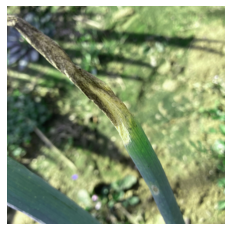

In [59]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 100.0
BLEU-4 score: 100.0

Real Caption: 잎에 노란색 반점과 분생포자가 발견되어 토마토 잎곰팡이병으로 생각됩니다
Predicted Caption: 잎에 노란색 반점과 분생포자가 발견되어 토마토 잎곰팡이병으로 생각됩니다


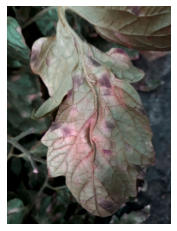

In [61]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

BLEU-1 score: 88.88888888888889
BLEU-2 score: 81.6496580927726
BLEU-3 score: 74.86196245806961
BLEU-4 score: 66.06328636027614

Real Caption: 검은 점이 잎에 있는 것으로 보아 콩점무늬병으로 판단됩니다
Predicted Caption: 검은 점이 콩 잎에 있는 것으로 보아 콩점무늬병으로 판단됩니다


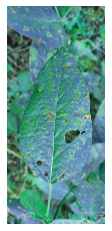

In [63]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

BLEU-1 score: 57.14285714285714
BLEU-2 score: 41.93139346887673
BLEU-3 score: 28.168855585454473
BLEU-4 score: 4.249232005220522e-76

Real Caption: 원형 반점과 황갈색 포자덩어리가 나타나고 말라 비틀어진 것을 보아 고추탄저병으로 의심됩니다
Predicted Caption: 고추에 움푹 들어간 원형 반점과 황갈색의 포자덩어리가 나타나며 말라 비틀어진 것으로 보아 고추탄저병으로 의심됩니다


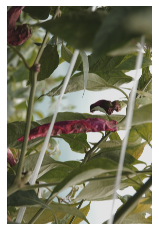

In [74]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

BLEU-1 score: 33.453839282436896
BLEU-2 score: 27.702410779900845
BLEU-3 score: 21.061608869051955
BLEU-4 score: 3.004969387521094e-76

Real Caption: 밀가루를 바른 것과 같은 포자와 담황색 병무늬가 나타나는 것으로 보아 애호박 흰가루병으로 의심됩니다
Predicted Caption: 애호박 잎에 담황색 병무늬가 발견되어 애호박 흰가루병으로 의심됩니다


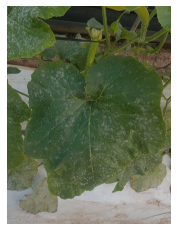

In [75]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

BLEU-1 score: 66.18726769384466
BLEU-2 score: 57.772983666542544
BLEU-3 score: 49.22477931233173
BLEU-4 score: 6.626356351409518e-76

Real Caption: 잎에 담황색 병무늬가 나타나는 것으로 보아 애호박 흰가루병으로 의심됩니다
Predicted Caption: 애호박 잎에 담황색 병무늬가 발견되어 애호박 흰가루병으로 의심됩니다


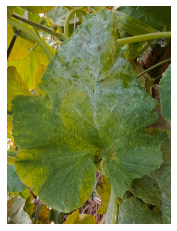

In [79]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

BLEU-1 score: 28.57142857142857
BLEU-2 score: 14.824986333222023
BLEU-3 score: 1.6099037441710956e-91
BLEU-4 score: 5.74340400309589e-153

Real Caption: 서릿발 모양의 포자가 넓게 나타나고 담황색 병무늬가 나타나는 것으로 보아 애호박 흰가루병으로 사료됩니다
Predicted Caption: 애호박 잎에 담황색 병무늬와 밀가루 바른 것과 같은 증상이 넓게 발견되어 애호박 흰가루병으로 의심됩니다


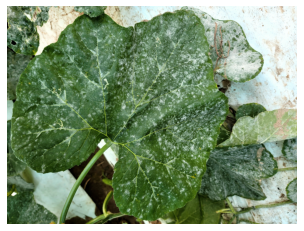

In [83]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']

#검증 데이터셋에서 랜덤으로 이미지를 선택한다
rid = np.random.randint(0, len(img_name_val)) #랜덤 아이디
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_weights = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#결과(result)에서 <end> 토큰을 제거한다
result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-1 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-4 score: {score*100}")

print()

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.axis('off')
plt.imshow(temp_image)

C:\Users\DI Lee\.keras\datasets\image.jpg
Prediction Caption: 애호박 잎에서 특별한 질병이 발견되지 않았기 때문에 정상으로 간주됩니다


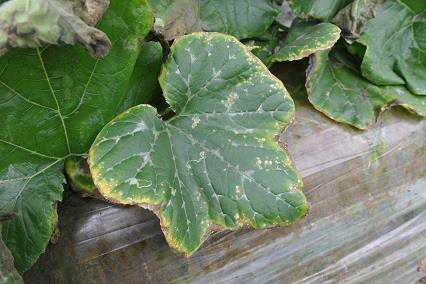

In [78]:
image_url = 'https://www.nongmin.com/upload/bbs/201708/20170801174600019/20170801174600019.jpg'
image_extension = image_url[-4:]
# print(image_extension)
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
print(image_path)
result,_, _ = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
# opening the image
Image.open(image_path)